In [1]:
import sys
sys.path.append("../")

In [2]:
from lightning_ocr.models import ABINetVision

model = ABINetVision.load_from_folder("checkpoints/abinet").eval()

In [3]:
from PIL import Image

pillow_image = Image.open("./datasets/MNIST/item_0.jpg").convert("RGB")
pillow_image

In [4]:
model.predict(pillow_image)

['50419']

In [5]:
model.to_onnx("abinet.onnx")

/home/mixaill76/lightning_ocr/examples/../lightning_ocr/models/abinet.py:78: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


In [6]:
import torch
import albumentations as A
import numpy as np

pipe = A.Compose(model.load_test_pipeline())
input_sample = torch.stack(
    [
        pipe(image=image)["image"]
        for image in [np.array(Image.open(f"./datasets/MNIST/item_{i}.jpg")) for i in range(3)]
    ],
    axis=0,
)
input_sample.shape, input_sample.dtype

(torch.Size([3, 3, 32, 128]), torch.float32)

In [7]:
import onnxruntime as ort

abinet_sess = ort.InferenceSession("abinet.onnx")
abinet_outputs = abinet_sess.run(
    ["output"], {"input": input_sample.detach().cpu().numpy()}
)

abinet_outputs[0].shape

(3, 12, 512)

In [8]:
np.max(abinet_outputs[0], axis=-1)

array([[0.9999981 , 0.6893805 , 0.99965894, 0.9998222 , 0.9998431 ,
        0.99929607, 0.99999297, 0.99999475, 0.9999918 , 0.9999945 ,
        0.99999464, 0.99999344],
       [0.99999785, 0.999716  , 0.9997683 , 0.9999523 , 0.99992156,
        0.9999826 , 0.99999213, 0.9999573 , 0.99997926, 0.9998534 ,
        0.99982697, 0.9999589 ],
       [0.999998  , 0.9999062 , 0.9998047 , 0.9998517 , 0.99995494,
        0.99984396, 0.9999943 , 0.99999607, 0.9999956 , 0.9999939 ,
        0.9999938 , 0.9999926 ]], dtype=float32)

In [9]:
raw_text = model.tokenizer.batch_decode(np.argmax(abinet_outputs[0], axis=-1))
raw_text

['<BOS>50419<EOS><EOS><EOS><EOS><EOS><EOS>',
 '<BOS>2131<EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 '<BOS>43536<EOS><EOS><EOS><EOS><EOS><EOS>']

In [10]:
text = model.tokenizer.batch_decode(np.argmax(abinet_outputs[0], axis=-1), skip_special_tokens=True)
text

['50419', '2131', '43536']

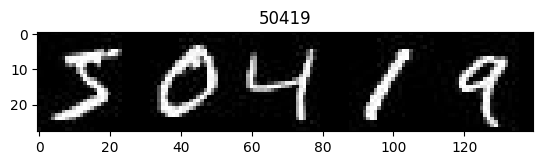

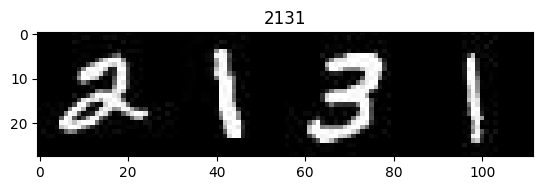

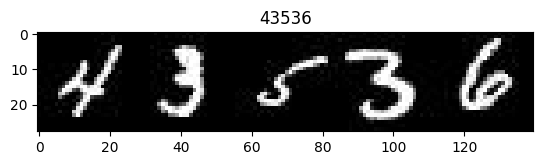

In [11]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.title(text[i])
    plt.imshow(Image.open(f"./datasets/MNIST/item_{i}.jpg"))
    plt.show()